In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe
import networkx as nx

import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt

from shapely.geometry import Point
from shapely.geometry import Polygon

import glob
import os
import itertools
import tqdm
import gc
import time
import pickle

from joblib import Parallel, delayed

In [2]:
import configparser
cfg = configparser.ConfigParser()
cfg.optionxform = str
cfg.read('/data/sarth/rootdir/assets/global.ini')
cfg = {s: dict(cfg.items(s)) for s in cfg.sections()}
PATHS = cfg['PATHS']

region_bounds = {
    'minx': -180,
    'miny': -60,
    'maxx': 180,
    'maxy': 90
}

lon_360_180 = lambda x: (x + 180) % 360 - 180 # convert 0-360 to -180-180
lon_180_360 = lambda x: x % 360 # convert -180-180 to 0-360

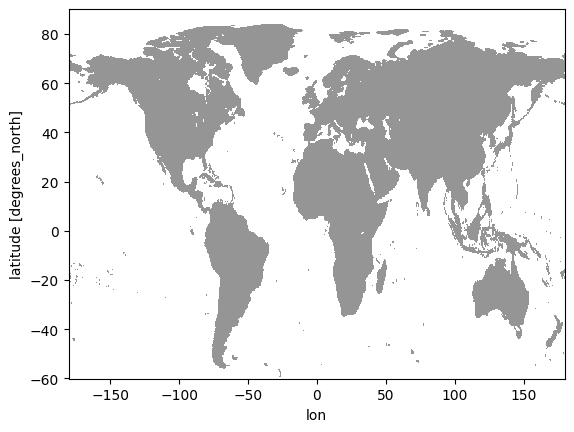

In [3]:
ds_land_sea_mask = xr.open_dataset(os.path.join(PATHS['ERA5'], 'land_sea_mask_static.nc'))
ds_land_sea_mask = ds_land_sea_mask.isel(time=0)
ds_land_sea_mask = ds_land_sea_mask.drop(['time'])
ds_land_sea_mask = ds_land_sea_mask.rename({'longitude': 'lon', 'latitude': 'lat'})
ds_land_sea_mask = ds_land_sea_mask['lsm']
ds_land_sea_mask['lon'] = [lon_360_180(lon) for lon in ds_land_sea_mask['lon'].values]
ds_land_sea_mask = ds_land_sea_mask.sortby('lon')
ds_land_sea_mask = ds_land_sea_mask.sel(
    lat = slice(region_bounds['maxy'], region_bounds['miny']), 
    lon = slice(region_bounds['minx'], region_bounds['maxx'])
)
ds_land_sea_mask = ds_land_sea_mask.where(ds_land_sea_mask <= 0, 1)
# Replace 0 with NaN
ds_land_sea_mask = ds_land_sea_mask.where(ds_land_sea_mask > 0)
ds_land_sea_mask.plot(cmap = 'Greys', add_colorbar = False)

# ERA5

In [4]:
var_names = [
    '2m_temperature', 
    'evaporation', 
    'snowfall', 
    'surface_net_solar_radiation', 
    'surface_net_thermal_radiation', 
    'surface_pressure', 
    'total_precipitation',
    '2m_dewpoint_temperature',
    '10m_u_component_of_wind',
    '10m_v_component_of_wind',
    'forecast_albedo',
    'potential_evaporation',
    'runoff',
    'snow_albedo',
    'snow_depth',
    'snowmelt',
    'sub_surface_runoff',
    'surface_runoff',
    'total_column_water',
    'volumetric_soil_water_layer_1',
    'volumetric_soil_water_layer_2',
    'volumetric_soil_water_layer_3',
    'volumetric_soil_water_layer_4'
]

for var_name in var_names:
    if not (os.path.exists(os.path.join(PATHS['Assets'], 'scaling', 'ERA5', f"{var_name}_mean.csv")) and os.path.exists(os.path.join(PATHS['Assets'], 'scaling', 'ERA5', f"{var_name}_std.csv"))):
        print(f"Processing {var_name}")
        ds = xr.open_mfdataset(os.path.join(PATHS['ERA5'], var_name, f"*.nc"), combine='by_coords')
        ds_var_name = list(ds.data_vars)[0]
        ds = ds[ds_var_name]
        ds = ds.rename({'longitude': 'lon', 'latitude': 'lat'})
        ds = ds.sel(time=~((ds['time.month'] == 2) & (ds['time.day'] == 29)))
        ds['lon'] = [lon_360_180(lon) for lon in ds['lon'].values]
        ds = ds.sortby('lon')
        ds = ds.sel(
            lat = slice(region_bounds['maxy'], region_bounds['miny']), 
            lon = slice(region_bounds['minx'], region_bounds['maxx'])
        )
        _, index = np.unique(ds['time'], return_index = True)
        ds = ds.isel(time = index)
        
        ds = ds.where(ds_land_sea_mask > 0)

        # Find mean and std of each year (single value for each year for entire region)
        ds_mean = ds.groupby('time.year').mean(['time', 'lat', 'lon'])
        ds_std = ds.groupby('time.year').std(['time', 'lat', 'lon'])
        
        os.makedirs(os.path.join(PATHS['Assets'], 'scaling', 'ERA5'), exist_ok = True)
        ds_mean.to_dataframe().to_csv(os.path.join(PATHS['Assets'], 'scaling', 'ERA5', f"{var_name}_mean.csv"))
        ds_std.to_dataframe().to_csv(os.path.join(PATHS['Assets'], 'scaling', 'ERA5', f"{var_name}_std.csv"))
    else:
        print(f"Skipping {var_name}")

Skipping 2m_temperature
Skipping evaporation
Skipping snowfall
Skipping surface_net_solar_radiation
Skipping surface_net_thermal_radiation
Skipping surface_pressure
Skipping total_precipitation
Processing 2m_dewpoint_temperature
Skipping 10m_u_component_of_wind
Skipping 10m_v_component_of_wind
Processing forecast_albedo
Skipping potential_evaporation
Skipping runoff
Processing snow_albedo
Skipping snow_depth
Processing snowmelt
Processing sub_surface_runoff
Processing surface_runoff
Processing total_column_water
Processing volumetric_soil_water_layer_1
Processing volumetric_soil_water_layer_2
Processing volumetric_soil_water_layer_3
Processing volumetric_soil_water_layer_4


# GLEAM

In [ ]:
data_source = 'GLEAM'
var_names = ['Ep', 'SMroot', 'SMsurf']
os.makedirs(os.path.join(PATHS['Assets'], 'scaling', data_source), exist_ok = True)

for var_name in itertools.islice(var_names,0,None,1):
    # scaling_mean_exists = os.path.exists(os.path.join(PATHS['Assets'], 'scaling', data_source, f"{var_name}_mean.csv"))
    # scaling_std_exists = os.path.exists(os.path.join(PATHS['Assets'], 'scaling', data_source, f"{var_name}_std.csv"))
    # if not (scaling_mean_exists and scaling_std_exists):
    print(f"Processing {var_name}")
    ds = xr.open_mfdataset(os.path.join(PATHS['GLEAM'], var_name, f"*.nc"), combine='by_coords')
    ds_var_name = list(ds.data_vars)[0]
    ds = ds[ds_var_name]
    ds = ds.sel(time=~((ds['time.month'] == 2) & (ds['time.day'] == 29)))

    for year in range(1980, 2020+1):
        start_date = f"{year}-01-01"
        end_date = f"{year}-12-31"
        ds_window = ds.sel(time=slice(start_date, end_date))
        start_time = time.time()
        ds_window.load()
        end_time = time.time()
        print(f"Time taken to load {year}: {(end_time - start_time)/60:.2f} mins")

        ds_mean = ds_window.groupby('time.year').mean(['time', 'lat', 'lon'])
        ds_std = ds_window.groupby('time.year').std(['time', 'lat', 'lon'])

        os.makedirs(os.path.join(PATHS['Assets'], 'scaling', data_source, var_name), exist_ok = True)
        ds_mean.to_dataframe().to_csv(os.path.join(PATHS['Assets'], 'scaling', data_source, var_name,f"{year}_mean.csv"))
        ds_std.to_dataframe().to_csv(os.path.join(PATHS['Assets'], 'scaling', data_source, var_name,f"{year}_std.csv"))

        del ds_window, ds_mean, ds_std
        gc.collect()

    # Clean the memory
    del ds
    # del ds_mean, ds_std
    gc.collect()
    # else:
    #     print(f"Skipping {var_name}")

# GLEAM4

In [3]:
data_source = 'GLEAM4'
var_names = ['Ep', 'SMrz', 'SMs', 'Eb', 'Ei', 'Es', 'Et', 'Ew', 'S', 'H']
os.makedirs(os.path.join(PATHS['Assets'], 'scaling', data_source), exist_ok = True)

for var_name in itertools.islice(var_names,0,None,1):
    print(f"Processing {var_name}")
    ds = xr.open_mfdataset(os.path.join(PATHS['GLEAM'], 'GLEAM4.2a', var_name, f"*.nc"), combine='by_coords')
    ds_var_name = list(ds.data_vars)[0]
    ds = ds[ds_var_name]
    ds = ds.sel(time=~((ds['time.month'] == 2) & (ds['time.day'] == 29)))

    # for year in tqdm.tqdm(range(1980, 2020+1)):
    for year in tqdm.tqdm(range(1999, 2008+1)):
        start_date = f"{year}-01-01"
        end_date = f"{year}-12-31"
        ds_window = ds.sel(time=slice(start_date, end_date))
        start_time = time.time()
        ds_window.load()
        end_time = time.time()
        # print(f"Time taken to load {year}: {(end_time - start_time)/60:.2f} mins")

        ds_mean = ds_window.groupby('time.year').mean(['time', 'lat', 'lon'])
        ds_std = ds_window.groupby('time.year').std(['time', 'lat', 'lon'])

        os.makedirs(os.path.join(PATHS['Assets'], 'scaling', data_source, var_name), exist_ok = True)
        ds_mean.to_dataframe().to_csv(os.path.join(PATHS['Assets'], 'scaling', data_source, var_name,f"{year}_mean.csv"))
        ds_std.to_dataframe().to_csv(os.path.join(PATHS['Assets'], 'scaling', data_source, var_name,f"{year}_std.csv"))

        del ds_window, ds_mean, ds_std
        gc.collect()

    # Clean the memory
    del ds
    # del ds_mean, ds_std
    gc.collect()
    # else:
    #     print(f"Skipping {var_name}")

Processing Ep


100%|██████████| 10/10 [18:09<00:00, 108.94s/it]


Processing SMrz


100%|██████████| 10/10 [16:27<00:00, 98.79s/it]


Processing SMs


100%|██████████| 10/10 [16:26<00:00, 98.63s/it]


Processing Eb


100%|██████████| 10/10 [15:52<00:00, 95.22s/it]


Processing Ei


100%|██████████| 10/10 [15:08<00:00, 90.82s/it]


Processing Es


100%|██████████| 10/10 [15:16<00:00, 91.61s/it]


Processing Et


100%|██████████| 10/10 [15:49<00:00, 94.93s/it]


Processing Ew


100%|██████████| 10/10 [16:20<00:00, 98.04s/it]


Processing S


100%|██████████| 10/10 [16:06<00:00, 96.66s/it]


Processing H


100%|██████████| 10/10 [18:00<00:00, 108.04s/it]


In [5]:
data_source = 'GLEAM4'
var_names = ['Ep', 'SMrz', 'SMs', 'Eb', 'Ei', 'Es', 'Et', 'Ew', 'S', 'H']
os.makedirs(os.path.join(PATHS['Assets'], 'scaling', data_source), exist_ok = True)

for var_name in itertools.islice(var_names,0,None,1):
    print(f"Processing {var_name}")
    ds = xr.open_mfdataset(os.path.join(PATHS['GLEAM'], 'GLEAM4.2a', var_name, f"*.nc"), combine='by_coords')
    ds_var_name = list(ds.data_vars)[0]
    ds = ds[ds_var_name]
    ds = ds.sel(time=~((ds['time.month'] == 2) & (ds['time.day'] == 29)))

    # for year in tqdm.tqdm(range(1980, 2020+1)):
    for year in tqdm.tqdm(range(1997, 1998+1)):
        start_date = f"{year}-01-01"
        end_date = f"{year}-12-31"
        ds_window = ds.sel(time=slice(start_date, end_date))
        start_time = time.time()
        ds_window.load()
        end_time = time.time()
        # print(f"Time taken to load {year}: {(end_time - start_time)/60:.2f} mins")

        ds_mean = ds_window.groupby('time.year').mean(['time', 'lat', 'lon'])
        ds_std = ds_window.groupby('time.year').std(['time', 'lat', 'lon'])

        os.makedirs(os.path.join(PATHS['Assets'], 'scaling', data_source, var_name), exist_ok = True)
        ds_mean.to_dataframe().to_csv(os.path.join(PATHS['Assets'], 'scaling', data_source, var_name,f"{year}_mean.csv"))
        ds_std.to_dataframe().to_csv(os.path.join(PATHS['Assets'], 'scaling', data_source, var_name,f"{year}_std.csv"))

        del ds_window, ds_mean, ds_std
        gc.collect()

    # Clean the memory
    del ds
    # del ds_mean, ds_std
    gc.collect()
    # else:
    #     print(f"Skipping {var_name}")

Processing Ep


100%|██████████| 2/2 [03:36<00:00, 108.32s/it]


Processing SMrz


100%|██████████| 2/2 [03:21<00:00, 100.63s/it]


Processing SMs


100%|██████████| 2/2 [03:24<00:00, 102.08s/it]


Processing Eb


100%|██████████| 2/2 [03:17<00:00, 98.79s/it]


Processing Ei


100%|██████████| 2/2 [03:06<00:00, 93.44s/it]


Processing Es


100%|██████████| 2/2 [03:08<00:00, 94.24s/it]


Processing Et


100%|██████████| 2/2 [03:13<00:00, 96.98s/it]


Processing Ew


100%|██████████| 2/2 [03:19<00:00, 99.68s/it] 


Processing S


100%|██████████| 2/2 [03:22<00:00, 101.31s/it]


Processing H


100%|██████████| 2/2 [03:42<00:00, 111.08s/it]


In [6]:
data_source = 'GLEAM4'
var_names = ['Ep', 'SMrz', 'SMs', 'Eb', 'Ei', 'Es', 'Et', 'Ew', 'S', 'H']

for var_name in var_names:
    df_mean = pd.DataFrame()
    df_std = pd.DataFrame()
    for year in range(1997, 2008+1):
        df_mean_temp = pd.read_csv(os.path.join(PATHS['Assets'], 'scaling', data_source, var_name, f"{year}_mean.csv"))
        df_std_temp = pd.read_csv(os.path.join(PATHS['Assets'], 'scaling', data_source, var_name, f"{year}_std.csv"))
        df_mean_temp['year'] = year
        df_std_temp['year'] = year
        df_mean = pd.concat([df_mean, df_mean_temp])
        df_std = pd.concat([df_std, df_std_temp])
    df_mean = df_mean.set_index('year')
    df_std = df_std.set_index('year')
    df_mean.columns = ['mean']
    df_std.columns = ['std']
    df = pd.concat([df_mean, df_std], axis = 1)
    df.to_csv(os.path.join(PATHS['Assets'], 'scaling', data_source, f"{var_name}.csv"))
    print(var_name)

Ep
SMrz
SMs
Eb
Ei
Es
Et
Ew
S
H
